 Credit Risk Prediction

# Problem Statement
The goal of this project is to predict whether a credit card customer is likely to default next month.
Since missing a defaulter can lead to significant financial loss, recall is prioritized over accuracy.


In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,roc_auc_score

)




In [60]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [61]:
df = df.drop('ID',axis=1)
df = df.rename(columns={"default.payment.next.month": "default_pay"})
df["default_pay"].value_counts(normalize=True)

,proportion
default_pay,
0,0.7788
1,0.2212


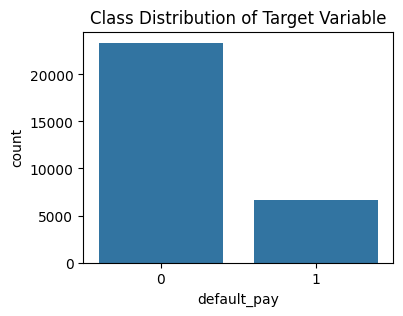

In [62]:
plt.figure(figsize=(4,3))
sns.countplot(x="default_pay", data=df)
plt.title("Class Distribution of Target Variable")
plt.show()


##Target Variable Distribution

The dataset is imbalanced, with fewer default cases compared to non-default cases.
Need to use of class-weighted models and recall-focused evaluation.

In [63]:
X = df.drop("default_pay", axis=1)
y = df["default_pay"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)


In [64]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [65]:
lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


              precision    recall  f1-score   support

           0       0.87      0.69      0.77      5841
           1       0.37      0.63      0.47      1659

    accuracy                           0.68      7500
   macro avg       0.62      0.66      0.62      7500
weighted avg       0.76      0.68      0.70      7500

ROC-AUC: 0.7160634862844689


# Baseline Model: Logistic Regression

Logistic Regression was used as an interpretable baseline model.
Class weighting was applied to handle class imbalance.


In [66]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.65      0.35      0.45      1659

    accuracy                           0.81      7500
   macro avg       0.74      0.65      0.67      7500
weighted avg       0.79      0.81      0.79      7500

ROC-AUC: 0.7587527175598405


In [67]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": lr.coef_[0]
}).sort_values(by="coefficient", ascending=False)

coef_df.head(10)


,feature,coefficient
5,PAY_0,0.579874
6,PAY_2,0.109273
13,BILL_AMT3,0.092278
7,PAY_3,0.089776
4,AGE,0.077706
15,BILL_AMT5,0.070038
8,PAY_4,0.046741
14,BILL_AMT4,0.021898
12,BILL_AMT2,0.017176
9,PAY_5,0.001469


In [68]:
rf_final = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

rf_final.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [69]:
thresholds = [0.25, 0.35, 0.5]

for t in thresholds:
    y_t = (y_prob_rf >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(confusion_matrix(y_test, y_t))
    print(classification_report(y_test, y_t))



Threshold: 0.25
[[4703 1138]
 [ 684  975]]
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5841
           1       0.46      0.59      0.52      1659

    accuracy                           0.76      7500
   macro avg       0.67      0.70      0.68      7500
weighted avg       0.78      0.76      0.77      7500


Threshold: 0.35
[[5198  643]
 [ 863  796]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5841
           1       0.55      0.48      0.51      1659

    accuracy                           0.80      7500
   macro avg       0.71      0.68      0.69      7500
weighted avg       0.79      0.80      0.79      7500


Threshold: 0.5
[[5524  317]
 [1081  578]]
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5841
           1       0.65      0.35      0.45      1659

    accuracy                           0.81      75

## Threshold Selection

Multiple probability thresholds were evaluated to analyze the trade-off between false negatives and false positives.

A threshold of **0.35** was selected as it significantly reduces missed defaulters while keeping false positives manageable.

In [70]:
y_prob_final = rf_final.predict_proba(X_test)[:, 1]

final_threshold = 0.35
y_pred_final = (y_prob_final >= final_threshold).astype(int)


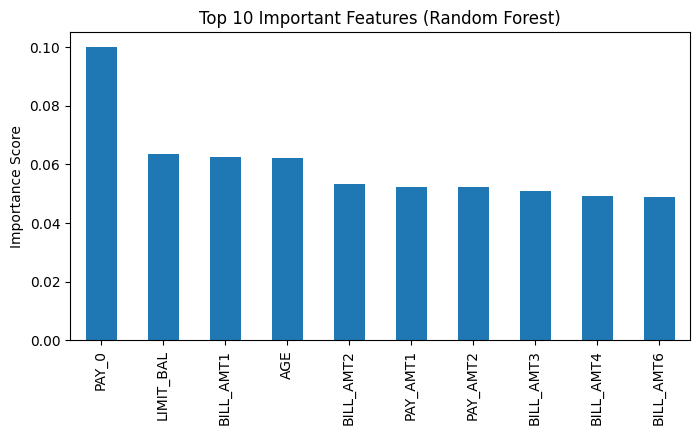

In [71]:
importances = pd.Series(
    rf_final.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,4))
importances.head(10).plot(kind="bar")
plt.title("Top 10 Important Features (Random Forest)")
plt.ylabel("Importance Score")
plt.show()


In [74]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_final))

print("Classification Report:")
print(classification_report(y_test, y_pred_final))


Confusion Matrix:
[[5198  643]
 [ 863  796]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      5841
           1       0.55      0.48      0.51      1659

    accuracy                           0.80      7500
   macro avg       0.71      0.68      0.69      7500
weighted avg       0.79      0.80      0.79      7500



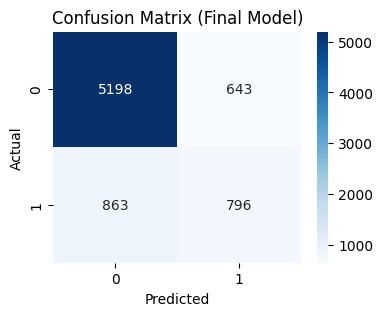

In [73]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Final Model)")
plt.show()


## Conclusion

The Random Forest model with a tuned probability threshold successfully reduced missed defaulters while maintaining reasonable false positives.


